In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

import sys
import datasets, metrics

sys.path.append('../')


In [2]:
trainfile = Path('../data/heart_train.parq').resolve()
testfile = Path('../data/heart_test.parq').resolve()
# trainfile = Path('../data/heart_big_train.parq').resolve()
# testfile = Path('../data/heart_big_test.parq').resolve()
trainfile, testfile

(WindowsPath('C:/Users/Admin/School/eindopdracht/data/heart_train.parq'),
 WindowsPath('C:/Users/Admin/School/eindopdracht/data/heart_test.parq'))

In [5]:
traindataset = datasets.HeartDataset2D(trainfile, target="target")
testdataset = datasets.HeartDataset2D(testfile, target="target")
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)

In [17]:
from mads_datasets.base import BaseDatastreamer
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from pathlib import Path
from typing import Dict

import ray
import torch
from filelock import FileLock
from loguru import logger
from mltrainer import ReportTypes, Trainer, TrainerSettings
from mltrainer.preprocessors import PaddedPreprocessor
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

import models

SAMPLE_INT = tune.search.sample.Integer
SAMPLE_FLOAT = tune.search.sample.Float

f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

def train(config: Dict):
    """
    The train function should receive a config file, which is a Dict
    ray will modify the values inside the config before it is passed to the train
    function.

    IMPORTANT: change model here if you want to actually use the transformer!
    """
    
    model = models.CNN(config) 
    model.to(device)

    trainersettings = TrainerSettings(
        epochs=10,
        metrics=[accuracy],
        logdir="heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),  # type: ignore
        reporttypes=[ReportTypes.RAY],
        scheduler_kwargs={"factor": 0.2, "patience": 5},
        earlystop_kwargs=None,
    )

    # because we set reporttypes=[ReportTypes.RAY]
    # the trainloop wont try to report back to tensorboard,
    # but will report back with ray
    # this way, ray will know whats going on,
    # and can start/pause/stop a loop.
    # This is why we set earlystop_kwargs=None, because we
    # are handing over this control to ray.

    trainer = Trainer(
        model=model,
        settings=trainersettings,
        loss_fn=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam,  # type: ignore
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    )

    trainer.loop()


In [ ]:
"""
The code below executes ray. It asseses the search space
using the configuration in config below.
Changing the config = hypertune
"""

from pathlib import Path

tune_dir = Path("../../models/ray/")
tune_dir.exists(), tune_dir.resolve()

if __name__ == "__main__":
    try:
        ray.init()
    except:
        ray.shutdown()
        ray.init()

    config = {
        # "input_size": 1, irrelevant
        "num_classes": 2,      #5 for big one
        "tune_dir": tune_dir,
        "hidden":  tune.randint(16, 128),
        "dropout":  tune.uniform(0.1, 0.4),
        "num_layers": tune.randint(2, 4),
    }

    reporter = CLIReporter()
    reporter.add_metric_column("accuracy")
    reporter.add_metric_column("precision")
    reporter.add_metric_column("recall")

    bohb_hyperband = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=50,
        reduction_factor=3,
        stop_last_trials=False,
    )

    bohb_search = TuneBOHB()

    analysis = tune.run(
        train,
        config=config,
        metric="test_loss",
        mode="min",
        progress_reporter=reporter,
        # local_dir=str(config["tune_dir"]),
        num_samples=50,
        search_alg=bohb_search,
        scheduler=bohb_hyperband,
        verbose=1,
    )

    ray.shutdown()


In [21]:
"""
This is a way to manually run a model using a config of your choice.
This is great to test the config I made with the hypertuning.
"""

from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=30,
    metrics=[accuracy, f1micro, f1macro, precision, recall],
    logdir="heart2D",
    train_steps=len(trainstreamer),
    valid_steps=len(teststreamer),
    reporttypes=[ReportTypes.TENSORBOARD],
    scheduler_kwargs={"factor": 0.2, "patience": 5},
    earlystop_kwargs=None
)
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer.stream(),
    validdataloader=teststreamer.stream(),
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau
    )
trainer.loop()

2024-01-30 12:42:39.098 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart2D\20240130-124239
100%|██████████| 363/363 [00:08<00:00, 41.32it/s]
2024-01-30 12:42:48.683 | INFO     | mltrainer.trainer:report:173 - Epoch 0 train 0.3724 test 0.2903 metric ['0.8799', '0.8799', '0.8526', '0.8799', '0.8739']
100%|██████████| 363/363 [00:09<00:00, 38.87it/s]
2024-01-30 12:42:58.815 | INFO     | mltrainer.trainer:report:173 - Epoch 1 train 0.2262 test 0.1794 metric ['0.9354', '0.9354', '0.9150', '0.9354', '0.9145']
100%|██████████| 363/363 [00:11<00:00, 32.07it/s]
2024-01-30 12:43:10.931 | INFO     | mltrainer.trainer:report:173 - Epoch 2 train 0.1472 test 0.1222 metric ['0.9576', '0.9576', '0.9455', '0.9576', '0.9495']
100%|██████████| 363/363 [00:29<00:00, 12.23it/s]
2024-01-30 12:43:43.112 | INFO     | mltrainer.trainer:report:173 - Epoch 3 train 0.1162 test 0.1222 metric ['0.9507', '0.9507', '0.9360', '0.9507', '0.9587']
100%|██████████| 363/363 [01:01<00:00,  5.93it/s]
2

KeyboardInterrupt: 

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

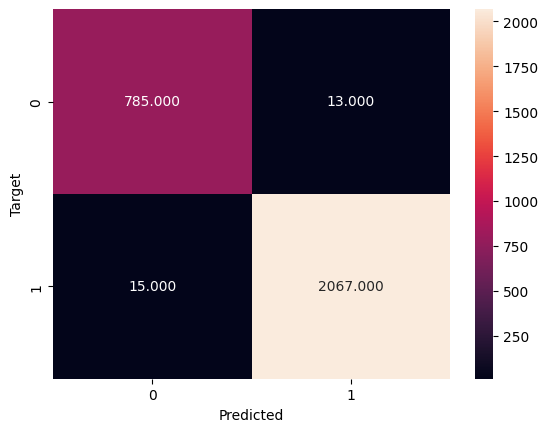

In [ ]:
"""
Precision + recall voor verslag:
"""

import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")